In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os


How to read csv file from drive i followed this link https://stackoverflow.com/questions/53619189/read-file-from-drive-in-google-colab

In [20]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
#data = pd.read_csv("/content/drive/My Drive/Reviews.csv")
con = sqlite3.connect(r"/content/drive/My Drive/database.sqlite")
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""",con)


In [22]:
print (data)

            Id  ...                                               Text
0            1  ...  I have bought several of the Vitality canned d...
1            2  ...  Product arrived labeled as Jumbo Salted Peanut...
2            3  ...  This is a confection that has been around a fe...
3            4  ...  If you are looking for the secret ingredient i...
4            5  ...  Great taffy at a great price.  There was a wid...
...        ...  ...                                                ...
525809  568450  ...  Great for sesame chicken..this is a good if no...
525810  568451  ...  I'm disappointed with the flavor. The chocolat...
525811  568452  ...  These stars are small, so you can give 10-15 o...
525812  568453  ...  These are the BEST treats for training and rew...
525813  568454  ...  I am very satisfied ,product is as advertised,...

[525814 rows x 10 columns]


The below code i am copying from my own assignment (Assignment number 4 from naive bayes where we already performed few data cleaning,data deplication etc processes)

In [23]:
# Change Score with 1 n 2 as -ve and 4 n 5 as +ve

def chng_to_0_or_1 (Score):
    if Score ==4 or Score ==5:
        return 1
    elif Score ==1 or Score ==2:
        return 0
    else:# Thus in case by some mistake any data is their with rating 6 or 7 etc due to some error is removed
        pass
currentScore = data["Score"]
new_Score = currentScore.map(chng_to_0_or_1)
data["Score"] = new_Score
print ("Number of data points available")
print (data.shape)#Gives original number of data points available


#2 Data Cleaning a.) Getting rid of duplicates and b.) if helpnessdenominator < helpfulnessnumerator


data = data.drop_duplicates(subset = ["UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time","Summary","Text"], keep='first', inplace=False)
print ("Number of data points after removing duplicates")
print (data.shape)#Gives data points are deduplication

# Reference: Copied from above cell  final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
data=data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]
print ("Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator ")
print (data.shape)

#3 Preprocessing begins

#Convert to lower case,convert shortcut words to proper words, remove Special Character

#i) Convert to lower case:
data["Text"] =  (data["Text"].str.lower())
data["Summary"] =  (data["Summary"].str.lower())

#ii) Convert Shortcuts words to proper words
#List of Words are:https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
#Reference:https://stackoverflow.com/questions/39602824/pandas-replace-string-with-another-string
data['Text'] = data['Text'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
##############Lets do the same for summary Text##################################
data['Summary'] = data['Summary'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
########################################################################################
# iii) Remove Special Characters except alpahbets and numbers
#The reason i dont want to remove number people might write got five eggs as 5 eggs or vice versa and dont want to lose 
#that information which could be useful
#Ref:https://stackoverflow.com/questions/33257344/how-to-remove-special-characers-from-a-column-of-dataframe-using-module-re
data["Text"]=data["Text"].map(lambda x: re.sub(r'[^a-zA-Z ]', '', x))
data["Summary_copy"]=data["Summary"].map(lambda x: re.sub(r'[^a-zA-Z ]', '', x))
import nltk
nltk.download("popular")

#The Summary are usually so small if we remove few stopwords the meaning itself would be complely lost or chamge
# So let us see what all stopwords we have
#Ref:::::::::https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist
#https://chrisalbon.com/machine_learning/preprocessing_text/remove_stop_words/

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['would','could','br','<br>','<','>','-','---br', '-----br','------br','-------j','', '-', '--', '---', '----', '-----', '------', '-------', '---------', '-------------------------', '----------------------------------------------------------------------------------------------------------------------------br', '------------------------------------------------------------------------------------------------------br', '---------------------------------------------------------------------------------------------------br', '-----------------------------------------------------------------------------------br', '--------------------------------------------------------------------------------br', '-------------------------------------------------------------------------------br', '--------------------------------------------------------------------------br', '-------------------------------------------------------------------------br', '---------------------------------------------------------------------br', '-------------------------------------------------------------------br', '-----------------------------------------------------------------br', '---------------------------------------------------------------br', '--------------------------------------------------------------br', '-------------------------------------------------------------br', '------------------------------------------------------------br', '-----------------------------------------------------------br', '---------------------------------------------------------br', '------------------------------------------------------br', '--------------------------------------------------br', '------------------------------------------------br', '-----------------------------------------------br', '---------------------------------------------br', '-------------------------------------------br', '------------------------------------------br', '---------------------------------------br', '-------------------------------------br', '-----------------------------------br', '---------------------------------br', '--------------------------------br', '-------------------------------br', '----------------------------br', '---------------------------br', '--------------------------br', '-------------------------br', '-----------------------br', '----------------------br', '---------------------br', '--------------------br', '--------------------old', '-------------------br', '-------------------update', '------------------br', '-----------------br', '----------------br', '----------------powdered--------wheatgrass', '---------------br', '--------------br', '-------------br', '------------br', '-----------br', '----------850mg--------------550mg------br', '----------br', '---------br', '---------j', '--------br', '-------br', '-------excelent', '-------j', '-------this', '------br', '------open', '-----br']
#newStopWords = ['would','could','br','<br>','<','>','-','---br', '-----br','------br','-------j','']
notstopwords = ['not','no','nor']
stopwords.extend(newStopWords)
stopwords = [word for word in stopwords if word not in notstopwords]

#  iv) For now let us just go with flow will use default stopwords as creating our own stop words is very time consuming
#Rather will use n-gram stratergy to get rid of problem of stopwords removal changing the meaning of sentences
#Ref:https://stackoverflow.com/questions/43184364/python-remove-stop-words-from-pandas-dataframe-give-wrong-output
data["New_Text"]= data['Text'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])
data["Summary"]= data['Summary'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])

#Ref:https://stackoverflow.com/questions/37347725/converting-a-panda-df-list-into-a-string/37347837
#we are creating new column New_summary so in case in future we need summary it is intact
data["New_Text"]=data["New_Text"].apply(' '.join)
data["Summary"]=data["Summary"].apply(' '.join)

# v) Now lets do Stemming
#https://stackoverflow.com/questions/48617589/beginner-stemming-in-pandas-produces-letters-not-stems
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
data["New_Text"] = data["New_Text"].apply(english_stemmer.stem)
data["Summary"] = data["Summary"].apply(english_stemmer.stem)
data["New_Text"] = data["New_Text"].astype(str)
data["Summary"] = data["Summary"].astype(str)

#vi) stemming without removing stop words
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
#https://stackoverflow.com/questions/34724246/attributeerror-float-object-has-no-attribute-lower
data["Text_with_stop"]=data["Text"].astype(str)
data["Summary"]=data["Summary"].astype(str)
data["Text_with_stop"]=data["Text_with_stop"].str.lower().map(english_stemmer.stem)
data["Summary"]=data["Summary"].str.lower().map(english_stemmer.stem)
data["Text_with_stop"]=data["Text_with_stop"].apply(''.join)
data["Summary"]=data["Summary"].apply(''.join)
data["Text_with_stop"] = data["Text_with_stop"].astype(str)
data["Summary"] = data["Summary"].astype(str)
################
# New_text_without_stop_convert as string
data["New_Text"] = data["New_Text"].astype(str)
data["New_Text"]=data["New_Text"].apply(''.join)
data["Summary"]=data["Summary"].apply(''.join)
data["Summary"] = data["Summary"].astype(str)
data["New_Text"] = data["New_Text"].astype(str)
print(data["Score"].value_counts())
print ("Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced \
dataset we first copy negative dataset 6 times than we sample with same number of times as positive")
# Let include another feature which is the length of the text 
data_neg = data[data["Score"] == 0]
data_pos = data[data["Score"] == 1]
data = pd.concat([data_pos,data_neg])
#https://stackoverflow.com/questions/46429033/how-do-i-count-the-total-number-of-words-in-a-pandas-dataframe-cell-and-add-thos
data["Text_length"]= (data["New_Text"].str.count(' ') + 1)
data["Summary_length"]= (data["Summary"].str.count(' ') + 1)
data["Time_formatted"]= pd.to_datetime(data["Time"])
data.sort_values(by=['Time_formatted'], inplace=True)



Number of data points available
(525814, 10)
Number of data points after removing duplicates
(366392, 10)
Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator 
(366390, 10)
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /ro

In [24]:
print (data)

            Id   ProductId  ... Summary_length                Time_formatted
138706  150524  0006641040  ...              3 1970-01-01 00:00:00.939340800
138683  150501  0006641040  ...              7 1970-01-01 00:00:00.940809600
417839  451856  B00004CXX9  ...              2 1970-01-01 00:00:00.944092800
212472  230285  B00004RYGX  ...              4 1970-01-01 00:00:00.944438400
417838  451855  B00004CXX9  ...              1 1970-01-01 00:00:00.946857600
...        ...         ...  ...            ...                           ...
478157  517064  B007OYUZIM  ...              1 1970-01-01 00:00:01.351209600
457460  494625  B0012VSXIM  ...              5 1970-01-01 00:00:01.351209600
42269    45991  B007VQQT1K  ...              3 1970-01-01 00:00:01.351209600
15069    16426  B007TJGZ54  ...              2 1970-01-01 00:00:01.351209600
479033  518008  B00529PFX6  ...              1 1970-01-01 00:00:01.351209600

[366390 rows x 16 columns]


So we see we have 16 rows few of them are copy. The eason we made copy so in case we need to use them in future incase our data gets corrupted due to some of our mistakes. But for now everything looks good. Lets make another dataframe with just 12 columns leaving copies and now we can operate on this new dataframe 

Also as number of rows is almost 3.5 lakhs which is taking us too long to compute lets us just take last 1.5 lakh rows to work on

In [25]:
#data.sort_values(by=['Time_formatted'], inplace=True)
data = data.tail(150000)
print (data)

            Id   ProductId  ... Summary_length                Time_formatted
57121    61959  B000CQG8K8  ...              3 1970-01-01 00:00:01.320451200
503701  544672  B001P3PR54  ...              3 1970-01-01 00:00:01.320451200
144439  156703  B002L35LH6  ...              3 1970-01-01 00:00:01.320451200
100504  109185  B003SE8CN2  ...              5 1970-01-01 00:00:01.320451200
128467  139421  B000EM8308  ...              1 1970-01-01 00:00:01.320451200
...        ...         ...  ...            ...                           ...
478157  517064  B007OYUZIM  ...              1 1970-01-01 00:00:01.351209600
457460  494625  B0012VSXIM  ...              5 1970-01-01 00:00:01.351209600
42269    45991  B007VQQT1K  ...              3 1970-01-01 00:00:01.351209600
15069    16426  B007TJGZ54  ...              2 1970-01-01 00:00:01.351209600
479033  518008  B00529PFX6  ...              1 1970-01-01 00:00:01.351209600

[150000 rows x 16 columns]


In [26]:
#data.sort_values(by=['Time_formatted'], inplace=True)
data_text= data['New_Text']
#data.sort_values(by=['Time_formatted'], inplace=True)
data_summary= data['Summary_copy']
#data.sort_values(by=['Time_formatted'], inplace=True)
new_data_x = data[['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Summary_copy','New_Text','Text_length','Summary_length','Time_formatted']]
new_data_y = data[['Score']]
data_text_summary = pd.concat([data_summary, data_text], axis=1, ignore_index=True)
data_text_summary.columns = ["Summary", "Text"]
print ("############################")
print ((data_text_summary))
merged_data_text_summary = pd.DataFrame()
merged_data_text_summary['Summary_Text'] = data_text_summary[['Summary', 'Text']].apply(lambda x: ' '.join(x), axis = 1)
print ("############################")
print ((merged_data_text_summary))
#X= new_data_x.values

############################
                                Summary                                               Text
57121            wonderful aromatic tea  tea wonderful treat cold night cinnamon aroma ...
503701          great treat for my dogs  one best products market cleaning dogs teeth o...
144439                 yummy lil things  not potato chip tortia chip seaweed paper form...
100504  its a hit   stopped smelly poop  product definitely hit two finicky cats one ye...
128467                             yuck  bought pregnant terrible morning sickness thin...
...                                 ...                                                ...
478157                         just bad  watery unpleasant like yoohoo mixed dirty dish...
457460      good  plenty licorice candy  like licorice love candy remember eating candy...
42269                   great irish tea  recently returned wonderful three week excursi...
15069                      super coffee  great coffee easy br

In [27]:
data_text_summary_train,data_text_summary_test = train_test_split(merged_data_text_summary, test_size=0.33, shuffle=False)
print (data_text_summary_train)

                                             Summary_Text
57121   wonderful aromatic tea tea wonderful treat col...
503701  great treat for my dogs one best products mark...
144439  yummy lil things not potato chip tortia chip s...
100504  its a hit   stopped smelly poop product defini...
128467  yuck bought pregnant terrible morning sickness...
...                                                   ...
88548   fantastic buy exact product large oriental mar...
15067   coffee flavored water excited see pack coffee ...
110968  too sweet and too artificial not impressed pro...
15033   very bland and weak coffee admit like strong f...
425885  sweet with a kick candies sweet chewy mean kic...

[100500 rows x 1 columns]


In [28]:
Y = new_data_y['Score'].values

y_train,y_test = train_test_split(Y, test_size=0.33, shuffle=False)
print ((y_train).shape)
print ((y_test).shape)

(100500,)
(49500,)


In [29]:
data_text_summary_train_val = data_text_summary_train.values
data_text_summary_test_val = data_text_summary_test.values


print (type(data_text_summary_train_val))
print ("Shape of data_text_summary_train is::")

print (data_text_summary_train_val.shape)
print ("First few row of data_text_summary_train looks like::")

print (data_text_summary_train_val)
print ("###########################################################")
print (type(data_text_summary_train_val.ravel()))
print ("###########################################################")
print (data_text_summary_train_val.ravel().shape)
print ("###########################################################")
print (type(data_text_summary_train['Summary_Text'].astype(str).values.shape))
print ("###########################################################")
#print (type(data_text_summary_train_val_xml))
print ("###########################################################")
#print ((data_text_summary_train_val_xml))


<class 'numpy.ndarray'>
Shape of data_text_summary_train is::
(100500, 1)
First few row of data_text_summary_train looks like::
[['wonderful aromatic tea tea wonderful treat cold night cinnamon aroma enticing buying years amazon always best pric']
 ['great treat for my dogs one best products market cleaning dogs teeth opinion like give treat day clean teeth noticed difference week']
 ['yummy lil things not potato chip tortia chip seaweed paper formbr please dont create bad review thinking something lunchbr seaweed paper form meant soup miso soup quick appetite supresant please give bad reviews items didnt research things dont understand']
 ...
 ['too sweet and too artificial not impressed product fact sitting pantry might possible brew cup strong coffee divide two run cappuccino add flavor']
 ['very bland and weak coffee admit like strong flavorful not burnt tasting coffee give four stars tully house blend breakfast blend quite weakbr ordering fifty husband desperation trying use putti

https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/

In [0]:
from keras.preprocessing.text import Tokenizer
# create the tokenizer
t1 = Tokenizer(num_words=5000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
t1.fit_on_texts(data_text_summary_train['Summary_Text'].astype(str).values)

# summarize what was learned
t1_word_count = (t1.word_counts)
t1_document_count = (t1.document_count)
t1_word_index = (t1.word_index)
t1_word_docs=(t1.word_docs)

text_to_seq_train = t1.texts_to_sequences(data_text_summary_train['Summary_Text'].astype(str).values)
text_to_seq_test = t1.texts_to_sequences(data_text_summary_test['Summary_Text'].astype(str).values)


In [31]:
print (list(t1_word_count.items())[:100])
print ((t1_document_count))
print (list(t1_word_index.items())[:150])
print (list(t1_word_docs.items())[:500])
print ("##################")
print ((text_to_seq_train[:1]))
print (text_to_seq_test[:1])

[('wonderful', 5025), ('aromatic', 210), ('tea', 24812), ('treat', 5140), ('cold', 2368), ('night', 1576), ('cinnamon', 2694), ('aroma', 1611), ('enticing', 43), ('buying', 4900), ('years', 6501), ('amazon', 14079), ('always', 6574), ('best', 18375), ('pric', 1088), ('great', 42261), ('for', 6797), ('my', 4676), ('dogs', 6541), ('one', 30522), ('products', 5315), ('market', 2106), ('cleaning', 303), ('teeth', 1565), ('opinion', 1227), ('like', 45706), ('give', 7327), ('day', 8131), ('clean', 1779), ('noticed', 1543), ('difference', 2065), ('week', 2296), ('yummy', 3602), ('lil', 88), ('things', 3589), ('not', 63868), ('potato', 1348), ('chip', 947), ('tortia', 1), ('seaweed', 246), ('paper', 805), ('formbr', 19), ('please', 1440), ('dont', 17379), ('create', 310), ('bad', 6073), ('review', 3555), ('thinking', 987), ('something', 6796), ('lunchbr', 33), ('form', 791), ('meant', 312), ('soup', 3055), ('miso', 260), ('quick', 2639), ('appetite', 220), ('supresant', 1), ('reviews', 3716), 

Lets see what is the average length of sentences. 

In [32]:
print(sum(map(len, text_to_seq_train[:245481])))
print ("Average length of sentences are:")
print (4025586/100500)
print ("###############")


4076411
Average length of sentences are:
40.05558208955224
###############


Also lets see sentence with highset number of words

In [33]:
def FindMaxLength(lst): 
    maxList = max((x) for x in lst) 
    maxLength = max(len(x) for x in lst ) 
  
    return maxList, maxLength

print(FindMaxLength(text_to_seq_train)) 


([4997, 674, 3596, 4997, 3596, 693, 1037, 1193, 3523, 2236, 22, 1, 487, 450, 162, 1306, 480, 451, 288, 74, 1011, 15, 302, 457, 555, 20, 305, 999, 693, 1037, 458, 28, 217, 1, 21], 1075)


In [34]:
max_review_length = 300
X_train = sequence.pad_sequences(text_to_seq_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(text_to_seq_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(100500, 300)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

Lets Try Single Layer LSTM first

In [39]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

epochs = 10
batch_size = 512

from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.layers.normalization import BatchNormalization


embed_vector_length = 32
model1 = Sequential()
model1.add(Embedding(5000, embed_vector_length, input_length=max_review_length,embeddings_initializer='random_normal'))
model1.add(Dropout(0.3))
model1.add(LSTM(100))
model1.add(BatchNormalization())
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Printing the Model Summary")
print(model1.summary())


Printing the Model Summary
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 32)           160000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 300, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               53200     
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 213,701
Trainable params: 213,501
Non-trainable params: 200
_________________________________________________________________
None


In [40]:
from keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

history1=model1.fit(X_train, y_train,batch_size=batch_size,epochs=epochs,callbacks=callbacks,verbose=1,validation_data=(X_test, y_test))

Train on 100500 samples, validate on 49500 samples
Epoch 1/10
100500/100500 [==============================] - 104s 1ms/step - loss: 0.3067 - acc: 0.8726 - val_loss: 0.2327 - val_acc: 0.9190
Epoch 2/10
100500/100500 [==============================] - 103s 1ms/step - loss: 0.1660 - acc: 0.9378 - val_loss: 0.2284 - val_acc: 0.9166
Epoch 3/10
100500/100500 [==============================] - 104s 1ms/step - loss: 0.1481 - acc: 0.9434 - val_loss: 0.1720 - val_acc: 0.9394
Epoch 4/10
100500/100500 [==============================] - 103s 1ms/step - loss: 0.1326 - acc: 0.9499 - val_loss: 0.1644 - val_acc: 0.9347
Epoch 5/10
100500/100500 [==============================] - 104s 1ms/step - loss: 0.1188 - acc: 0.9545 - val_loss: 0.1844 - val_acc: 0.9342
Epoch 6/10
100500/100500 [==============================] - 100s 995us/step - loss: 0.1080 - acc: 0.9586 - val_loss: 0.1618 - val_acc: 0.9424
Epoch 7/10
100500/100500 [==============================] - 98s 975us/step - loss: 0.1028 - acc: 0.9605 - v

In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [0]:
x = list(range(1,epochs+1))

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

scores1 = model1.evaluate(X_test, y_test, verbose=0)


Test score: 0.1802538271431971
Test accuracy: 0.9388686868542373


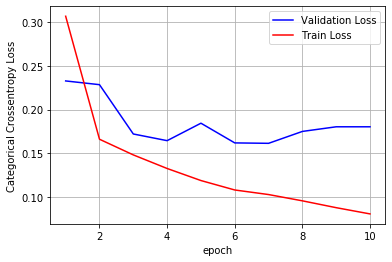

In [43]:
print('Test score:', scores1[0]) 
print('Test accuracy:', scores1[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
vy1 = history1.history['val_loss']
ty1 = history1.history['loss']
plt_dynamic(x, vy1, ty1, ax)

Now lets dig in 2 layer LSTM model

In [35]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

epochs = 10
batch_size = 512

from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.layers.normalization import BatchNormalization


embed_vector_length = 32
model2 = Sequential()
model2.add(Embedding(5000, embed_vector_length, input_length=max_review_length,embeddings_initializer='random_normal'))
model2.add(Dropout(0.3))
model2.add(LSTM(100, return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(100))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Printing the Model Summary")
print(model2.summary())


Printing the Model Summary
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 32)           160000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 100)          53200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 300, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)            

https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/

In [36]:
from keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

history2=model2.fit(X_train, y_train,batch_size=batch_size,epochs=epochs,callbacks=callbacks,verbose=1,validation_data=(X_test, y_test))

Train on 100500 samples, validate on 49500 samples
Epoch 1/10
100500/100500 [==============================] - 197s 2ms/step - loss: 0.3352 - acc: 0.8631 - val_loss: 0.1803 - val_acc: 0.9318
Epoch 2/10
100500/100500 [==============================] - 195s 2ms/step - loss: 0.1688 - acc: 0.9366 - val_loss: 0.1670 - val_acc: 0.9359
Epoch 3/10
100500/100500 [==============================] - 197s 2ms/step - loss: 0.1446 - acc: 0.9454 - val_loss: 0.1636 - val_acc: 0.9343
Epoch 4/10
100500/100500 [==============================] - 200s 2ms/step - loss: 0.1303 - acc: 0.9508 - val_loss: 0.1895 - val_acc: 0.9278
Epoch 5/10
100500/100500 [==============================] - 203s 2ms/step - loss: 0.1217 - acc: 0.9534 - val_loss: 0.1839 - val_acc: 0.9301
Epoch 6/10
100500/100500 [==============================] - 204s 2ms/step - loss: 0.1108 - acc: 0.9576 - val_loss: 0.1582 - val_acc: 0.9402
Epoch 7/10
100500/100500 [==============================] - 206s 2ms/step - loss: 0.1032 - acc: 0.9604 - val_

In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [0]:
x = list(range(1,epochs+1))

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

scores2 = model2.evaluate(X_test, y_test, verbose=0)


Test score: 0.1749505036221911
Test accuracy: 0.9403434343289847


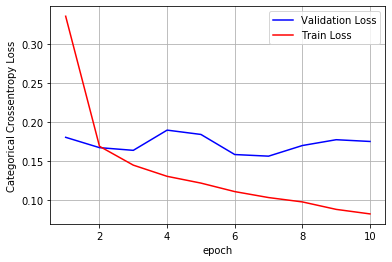

In [47]:
print('Test score:', scores2[0]) 
print('Test accuracy:', scores2[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
vy2 = history2.history['val_loss']
ty2 = history2.history['loss']
plt_dynamic(x, vy2, ty2, ax)

Conclusion:

Both the model single and double layer LSTM performed very well. Both being around 95% accurate